In [1]:
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from mapping import JordanWigner
service = QiskitRuntimeService()
from estimator import Estimator
from estimator import BasicEstimator

In [2]:
from qiskit import IBMQ

IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-sherbrooke', group='udes', project='quicophy')>,
 <AccountProvider for IBMQ(hub='ibm-q-qida', group='iq-qantum-hub', project='quicophy')>,
 <AccountProvider for IBMQ(hub='ibm-q-qida', group='iq-quantum', project='quicophy')>,
 <AccountProvider for IBMQ(hub='ibm-q-qida', group='pinq2', project='winter-school')>]

In [3]:
# The provider and backend that you will use for the winter school
provider = IBMQ.get_provider(hub='ibm-q-qida', group='pinq2', project='winter-school')
ibm_simulator = provider.get_backend('ibmq_qasm_simulator')
oslo = provider.get_backend('ibm_oslo')

<b>Measurement Error mitigation<b>

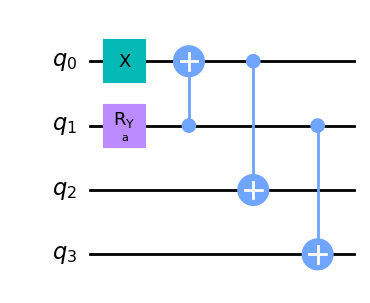

In [4]:
varform_4qubits_1param = QuantumCircuit(4)
a = Parameter('a')

varform_4qubits_1param.ry(a,1)
varform_4qubits_1param.x(0)
varform_4qubits_1param.cx(1,0)
varform_4qubits_1param.cx(0,2)
varform_4qubits_1param.cx(1,3)


varform_4qubits_1param.draw('mpl')

In [5]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.circuit import QuantumRegister
from qiskit import execute

/var/folders/z6/4vq2qqgs2078v53wjbxszb8h0000gn/T/ipykernel_1361/3054509103.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [ ]:
qr = QuantumRegister(4)

cal_circuits, state_labels = complete_meas_cal(qr=varform_4qubits_1param.qregs[0], 
                                               circlabel='measurement_calibration')

cal_job = execute(cal_circuits,
                 oslo,
                 shots=1024,
                 optimization_level=0).result()

#print(cal_job.job_id())
#job_monitor(cal_job)
meas_fitter = CompleteMeasFitter(cal_job, state_labels)
meas_filter = meas_fitter.filter

In [ ]:
varform = varform_4qubits_1param
backend = oslo
execute_opts = {'shots' : 1024}
estimator = BasicEstimator(varform,backend,execute_opts = execute_opts,measure_filter=meas_filter)

In [14]:
from scipy.optimize import minimize
minimizer = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP', 
    options = {'maxiter' : 5,'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 2})

In [ ]:
from pyscf import gto
from hamiltonian import MolecularFermionicHamiltonian

In [ ]:
distance = [0.2, 0.4, 0.6, 0.73, 0.9, 1.0, 1.2, 1.5, 1.6] #units in AA
GS = []
for d in distance:
    mol = gto.M(
        atom = [['H', (0,0,-d/2)], ['H', (0,0,d/2)]], 
        basis = 'sto-3g'
        )
    energy_nuc = mol.energy_nuc()
    molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
    molecular_hamiltonian = molecular_hamiltonian_no_spin.include_spin()
    
    mapping = JordanWigner()
    qubit_hamiltonian = mapping.fermionic_hamiltonian_to_qubit_hamiltonian(molecular_hamiltonian).apply_threshold().combine().apply_threshold().sort()
    estimator.set_observable(qubit_hamiltonian)

    params = [0,]
    vqe_solver = VQESolver(qubit_hamiltonian,minimizer,[0,],name = 'vqe_solver')
    opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)
    GS.append(opt_value+energy_nuc)